In [1]:

import networkx as nx
import matplotlib.pyplot as plt
import itertools
import heapq
import time
import sys

print("Libraries imported successfully.")

Libraries imported successfully.


In [2]:

locations = ['Warehouse', 'C1', 'C2', 'C3']

distance_matrix = [
    [0, 4, 8, 6],
    [4, 0, 5, 7],
    [8, 5, 0, 3],
    [6, 7, 3, 0]
]

parcels = {
    'C1': {'value': 50, 'time': (9, 12), 'weight': 10},
    'C2': {'value': 60, 'time': (10, 13), 'weight': 20},
    'C3': {'value': 40, 'time': (11, 14), 'weight': 15}
}


VEHICLE_CAPACITY = 30

print("Input data loaded.")

Input data loaded.


In [3]:
# Greedy Strategy for Parcel Selection

def select_parcels_greedy(parcels, capacity):
    items = []
    for loc, data in parcels.items():
        ratio = data['value'] / data['weight']
        items.append({
            'loc': loc,
            'weight': data['weight'],
            'value': data['value'],
            'ratio': ratio
        })

    # Sort items by ratio in descending order (Greedy choice)
    items.sort(key=lambda x: x['ratio'], reverse=True)

    selected_locations = []
    current_weight = 0
    total_value = 0

    print(f"--- Greedy Selection (Capacity: {capacity}) ---")
    for item in items:
        if current_weight + item['weight'] <= capacity:
            current_weight += item['weight']
            total_value += item['value']
            selected_locations.append(item['loc'])
            print(f"Selected {item['loc']}: Val {item['value']}, Wgt {item['weight']} (Ratio {item['ratio']:.2f})")
        else:
            print(f"Skipped {item['loc']}: Wgt {item['weight']} (Exceeds remaining capacity)")

    return selected_locations, total_value

# Run the selection
selected_locs, val = select_parcels_greedy(parcels, VEHICLE_CAPACITY)
print(f"\nFinal Selected Locations: {selected_locs}")
print(f"Total Value: {val}")

--- Greedy Selection (Capacity: 30) ---
Selected C1: Val 50, Wgt 10 (Ratio 5.00)
Selected C2: Val 60, Wgt 20 (Ratio 3.00)
Skipped C3: Wgt 15 (Exceeds remaining capacity)

Final Selected Locations: ['C1', 'C2']
Total Value: 110


In [4]:
# Recurrence-Based Cost Estimation

def delivery_cost_recursive(current_node, visited_mask, n, dist_matrix, memo):
    # Base case: If all cities are visited (mask is all 1s), return distance to Warehouse (index 0)
    if visited_mask == (1 << n) - 1:
        return dist_matrix[current_node][0]

    state = (current_node, visited_mask)
    if state in memo:
        return memo[state]

    min_dist = float('inf')

    # Try visiting every unvisited city
    for next_city in range(n):
        if not (visited_mask & (1 << next_city)):
            # Recurrence: Cost to next city + Cost from next city to finish
            new_cost = dist_matrix[current_node][next_city] + \
                       delivery_cost_recursive(next_city, visited_mask | (1 << next_city), n, dist_matrix, memo)
            min_dist = min(min_dist, new_cost)

    memo[state] = min_dist
    return min_dist


n_total = len(locations)
memo_dict = {}
# Start at Warehouse (0), visited mask 1 (binary 0001)
theoretical_min_cost = delivery_cost_recursive(0, 1, n_total, distance_matrix, memo_dict)
print(f"Theoretical Minimum Cost (visiting ALL nodes): {theoretical_min_cost}")

Theoretical Minimum Cost (visiting ALL nodes): 18


In [5]:
#  Graph Algorithms (Dijkstra & MST)

def dijkstra_shortest_path(start_idx, n, dist_matrix):

    distances = [float('inf')] * n
    distances[start_idx] = 0
    visited = [False] * n
    pq = [(0, start_idx)] # (distance, node)

    while pq:
        d, u = heapq.heappop(pq)
        if visited[u]: continue
        visited[u] = True

        for v in range(n):
            if dist_matrix[u][v] > 0:
                if d + dist_matrix[u][v] < distances[v]:
                    distances[v] = d + dist_matrix[u][v]
                    heapq.heappush(pq, (distances[v], v))
    return distances

def prim_mst(n, dist_matrix):
    key = [float('inf')] * n
    parent = [None] * n
    key[0] = 0
    mst_set = [False] * n
    pq = [(0, 0)]

    mst_cost = 0
    edges = []

    while pq:
        w, u = heapq.heappop(pq)
        if mst_set[u]: continue
        mst_set[u] = True
        mst_cost += w
        if parent[u] is not None:
            edges.append((parent[u], u))

        for v in range(n):
            if 0 < dist_matrix[u][v] < key[v] and not mst_set[v]:
                key[v] = dist_matrix[u][v]
                parent[v] = u
                heapq.heappush(pq, (key[v], v))
    return mst_cost, edges

# Execute
shortest_paths = dijkstra_shortest_path(0, len(locations), distance_matrix)
mst_cost, mst_edges = prim_mst(len(locations), distance_matrix)

print(f"Shortest times from Warehouse: {shortest_paths}")
print(f"MST Cost: {mst_cost}, Edges: {mst_edges}")

Shortest times from Warehouse: [0, 4, 8, 6]
MST Cost: 12, Edges: [(0, 1), (1, 2), (2, 3)]


In [6]:
# TSP Brute Force & Profiling

def tsp_brute_force(node_names, all_locations, dist_matrix):
    """
    Finds the optimal route visiting specific 'node_names' and returning to start.
    """
    # Map names to indices
    loc_map = {name: i for i, name in enumerate(all_locations)}
    target_indices = [loc_map[name] for name in node_names if name != 'Warehouse']
    warehouse_idx = 0

    min_route_cost = float('inf')
    best_permutation = []

    # Measure time
    start_time = time.time()

    # Try all permutations of the targets
    for perm in itertools.permutations(target_indices):
        current_cost = 0
        curr = warehouse_idx

        # Warehouse -> First -> Second ...
        for next_node in perm:
            current_cost += dist_matrix[curr][next_node]
            curr = next_node

        # ... -> Warehouse
        current_cost += dist_matrix[curr][warehouse_idx]

        if current_cost < min_route_cost:
            min_route_cost = current_cost
            best_permutation = perm

    end_time = time.time()

    # Reconstruct route
    optimal_path_indices = [warehouse_idx] + list(best_permutation) + [warehouse_idx]
    optimal_path_names = [all_locations[i] for i in optimal_path_indices]

    return optimal_path_names, min_route_cost, (end_time - start_time)

# Run TSP on the Greedy Selection results from Cell 3
nodes_to_visit = ['Warehouse'] + selected_locs
opt_route, opt_cost, exec_time = tsp_brute_force(nodes_to_visit, locations, distance_matrix)

print(f"Optimal Route: {opt_route}")
print(f"Total Distance: {opt_cost}")
print(f"Time Taken: {exec_time:.6f} seconds")

Optimal Route: ['Warehouse', 'C1', 'C2', 'Warehouse']
Total Distance: 17
Time Taken: 0.000011 seconds


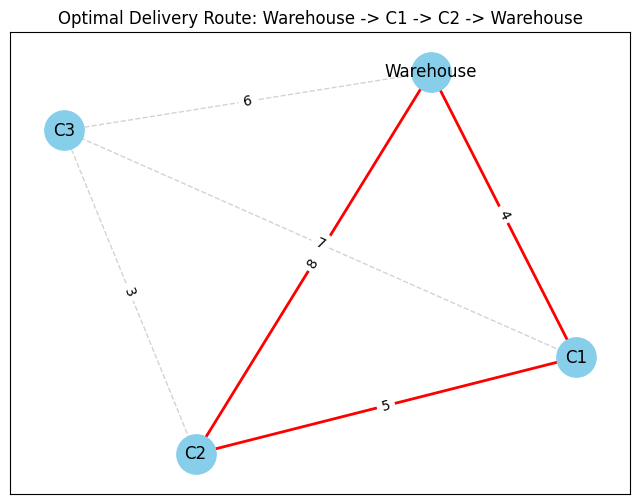

In [7]:
#  Visualization

def visualize_delivery_network(all_locs, dist_matrix, path_names):
    G = nx.Graph()
    n = len(all_locs)

    # Add nodes and all edges
    for i in range(n):
        G.add_node(all_locs[i])
        for j in range(i+1, n):
            G.add_edge(all_locs[i], all_locs[j], weight=dist_matrix[i][j])

    pos = nx.spring_layout(G, seed=42) # Fixed layout

    plt.figure(figsize=(8, 6))

    # Draw all edges (background)
    nx.draw_networkx_edges(G, pos, style='dashed', edge_color='lightgray')

    # Highlight Optimal Path
    path_edges = []
    for k in range(len(path_names)-1):
        path_edges.append((path_names[k], path_names[k+1]))

    nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='red', width=2)

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=800)
    nx.draw_networkx_labels(G, pos)

    # Draw edge labels (weights)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    plt.title(f"Optimal Delivery Route: {' -> '.join(path_names)}")
    plt.show()

# Visualize results
visualize_delivery_network(locations, distance_matrix, opt_route)